<a href="https://colab.research.google.com/github/alexshtf/alexshtf.github.io/blob/fix_spectrum_norms/assets/spectrum_power_stability_robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib

matplotlib.rcParams['figure.dpi'] = 120

# Eliminate redundancy

In [2]:
import torch
from torch import nn

class Nondecreasing(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        init = torch.linspace(-1, 1, dim)
        self.start = nn.Parameter(init[:1])
        self.increments = nn.Parameter(init.diff().expm1().log())

    def forward(self):
        return torch.cat([
            self.start,
            self.start + nn.functional.softplus(self.increments).cumsum(dim=0)
        ])

In [3]:
Nondecreasing(10)()

tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000], grad_fn=<CatBackward0>)

In [4]:
import torch.linalg as tla

class MultivariateSpectral(nn.Module):
    def __init__(self, *, num_features: int, dim: int, eigval_idx: int):
        super().__init__()
        self.eigval_idx = eigval_idx
        self.mu = Nondecreasing(dim)
        self.A = nn.Parameter(
            torch.randn(num_features, dim, dim) / (math.sqrt(dim) * num_features)
        )

    def forward(self, x):
        # batches of sum of x[i] * A[i]
        nf, dim = self.A.shape[:2]
        feature_mat = (x @ self.A.view(nf, dim * dim)).view(-1, dim, dim)

        # diag(mu) replicated per batch
        bias_mat = torch.diagflat(self.mu()).expand_as(feature_mat)

        # batched eigenvalue computation
        eigvals = tla.eigvalsh(bias_mat + feature_mat)
        return eigvals[..., self.eigval_idx]

In [5]:
def f(x, y):
    return -torch.log(torch.exp(x-1) + torch.exp(y+0.5) + torch.exp(-x-y+0.5))

# sample 10000 points on the graph of the function
x = torch.empty(10000).uniform_(-3, 3)
y = torch.empty(10000).uniform_(-3, 3)
xy = torch.stack([x, y], dim=-1)
z = f(x, y) + 0.2 * torch.randn(10000)

In [ ]:
import math
from itertools import count

model = MultivariateSpectral(num_features=2, dim=5, eigval_idx=0)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 10
print_every = 100

cum_loss = 0.
for i, xyb, zb in zip(count(), xy.split(batch_size), z.split(batch_size)):
    loss = (model(xyb) - zb).square().mean()
    cum_loss += loss.detach().item()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if (i + 1) % print_every == 0:
        print(f'Loss = {cum_loss / print_every:.4f}')
        cum_loss = 0.

Loss = 0.4582
Loss = 0.1355
Loss = 0.0774
Loss = 0.0649
Loss = 0.0626
Loss = 0.0520
Loss = 0.0534
Loss = 0.0516
Loss = 0.0464
Loss = 0.0468


# Spectral stability - demo

In [6]:
import pandas as pd

train_df = pd.read_csv('sample_data/california_housing_train.csv')
test_df = pd.read_csv('sample_data/california_housing_test.csv')

In [7]:
import numpy as np

skewed_columns = ['total_rooms', 'total_bedrooms', 'population', 'households']
train_df[skewed_columns] = train_df[skewed_columns].apply(np.log)
test_df[skewed_columns] = test_df[skewed_columns].apply(np.log)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform='pandas')
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

label_scale = float(scaler.scale_[-1])

In [9]:
from torch import as_tensor

def to_tensors(df):
    target = 'median_house_value'
    return (
        as_tensor(df.drop(target, axis=1).values, dtype=torch.float32),
        as_tensor(df[target].values, dtype=torch.float32)
    )

X_train, y_train = to_tensors(train_scaled)
X_test, y_test = to_tensors(test_scaled)

num_features = X_train.shape[1]
feature_names = train_df.columns[:num_features].tolist()
n_train = len(X_train)

In [10]:
def train_epoch(
        device, net, optimizer, criterion, regularizer, X_batches, y_batches
    ):
    epoch_loss = torch.zeros(1).to(device)
    for x, y in zip(X_batches, y_batches):
        optimizer.zero_grad()
        loss = criterion(net(x), y)
        cost = loss + regularizer(net)
        cost.backward()

        with torch.no_grad():
            epoch_loss += loss * x.shape[0]
        optimizer.step()
    return (epoch_loss / n_train).cpu().item()


def train_model_stream(
        net, criterion, *, n_epochs=200, batch_size=10, lr=1e-4, regularizer=None
    ):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    regularizer = regularizer or (lambda model: 0.)

    net.to(device)
    X_train_batches = X_train.to(device).split(batch_size)
    y_train_batches = y_train.to(device).split(batch_size)
    X_test_device = X_test.to(device)
    y_test_device = y_test.to(device)

    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    for epoch in range(1, 1 + n_epochs):
        train_loss = train_epoch(
            device, net, optimizer, criterion, regularizer,
            X_train_batches, y_train_batches
        )

        with torch.no_grad():
            test_loss = criterion(net(X_test_device), y_test_device)
            test_loss = test_loss.cpu().item()

        yield {
            'step': epoch,
            'model': net,
            'train_error': math.sqrt(train_loss) * label_scale,
            'test_error': math.sqrt(test_loss) * label_scale,
        }

In [ ]:
model = MultivariateSpectral(num_features=num_features, dim=5, eigval_idx=2)
criterion = nn.MSELoss()
for event in train_model_stream(model, criterion, n_epochs=5):
    print(event['step'], event['train_error'], event['test_error'], sep='\t')

1	109072.75280327671	99536.88016316161
2	95295.4091119307	89540.08167748511
3	86628.42283455568	82857.71197495822
4	80906.37794419663	78535.01666073261
5	77319.691256485	75821.19027087984


In [11]:
def add_spectral_norms(stream):
    for event in stream:
        model = event['model']
        with torch.no_grad():
            matrices_sym = \
                model.A.tril() + model.A.tril(diagonal=-1).transpose(-1, -2)
            norms = tla.matrix_norm(matrices_sym, ord=2)
            norms = norms.ravel().cpu().tolist()

        yield {
            'step': event['step'],
            'train_error': event['train_error'],
            'test_error': event['test_error'],
        } | {
            f'norm_{feature_name}': norm
            for feature_name, norm in zip(feature_names, norms)
        }

In [ ]:
from rich.pretty import pprint

model = MultivariateSpectral(num_features=num_features, dim=5, eigval_idx=2)
criterion = nn.MSELoss()
for event in add_spectral_norms(train_model_stream(model, criterion, n_epochs=2)):
    pprint(event, indent_guides=False)

{
    'step': 1,
    'train_error': 105523.77536281559,
    'test_error': 97731.75678823328,
    'norm_longitude': 0.12640513479709625,
    'norm_latitude': 0.1759399175643921,
    'norm_housing_median_age': 0.15713410079479218,
    'norm_total_rooms': 0.17977216839790344,
    'norm_total_bedrooms': 0.16544003784656525,
    'norm_population': 0.19817979633808136,
    'norm_households': 0.2670281231403351,
    'norm_median_income': 0.33458226919174194
}

{
    'step': 2,
    'train_error': 94575.6796415192,
    'test_error': 88766.7939206047,
    'norm_longitude': 0.15076042711734772,
    'norm_latitude': 0.1756560057401657,
    'norm_housing_median_age': 0.1784549206495285,
    'norm_total_rooms': 0.18125228583812714,
    'norm_total_bedrooms': 0.15172506868839264,
    'norm_population': 0.19934602081775665,
    'norm_households': 0.26696428656578064,
    'norm_median_income': 0.47850197553634644
}

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import PillowWriter

def plot_progress(events, max_step, recording_path='video.gif'):
    # create a plot with two axes - one for errors, one for norms
    fig, (err_ax, norm_ax) = plt.subplots(
        2, 1, figsize=(8, 8), layout='constrained'
    )

    # ceate empty line objects
    def plot_empty(ax, label):
        return ax.plot([], [], label=label)[0]

    line_dict = {
        'train_error': plot_empty(err_ax, 'train error'),
        'test_error': plot_empty(err_ax, 'test error'),
    } | {
        f'norm_{feature_name}': plot_empty(norm_ax, feature_name)
        for feature_name in feature_names
    }

    # setup axis properties
    err_ax.set_title("Error")
    norm_ax.set_title("Matrix norms")
    for ax in (err_ax, norm_ax):
        ax.set_xlabel("Step")
        ax.set_xlim(0, max_step)
        ax.grid(True)
        ax.legend()


    # display figure and obtain its handle
    h = display(fig, display_id=True)
    plt.close(fig)

    writer = PillowWriter(fps=10)
    writer.setup(fig, recording_path, dpi=120)

    # iterate over events and update the plot
    min_test_error = float('inf')
    for event in events:
        step = event['step']
        min_test_error = min(min_test_error, event['test_error'])
        err_ax.set_title(f'Error (min test err = {min_test_error:.2f})')

        for key, line in line_dict.items():
            value = event[key]
            x, y = line.get_data(orig=True)
            line.set_data(np.append(x, step), np.append(y, value))

        for axs in (err_ax, norm_ax):
            axs.relim()
            axs.autoscale_view()

        fig.canvas.draw()
        h.update(fig)
        writer.grab_frame()

    writer.finish()

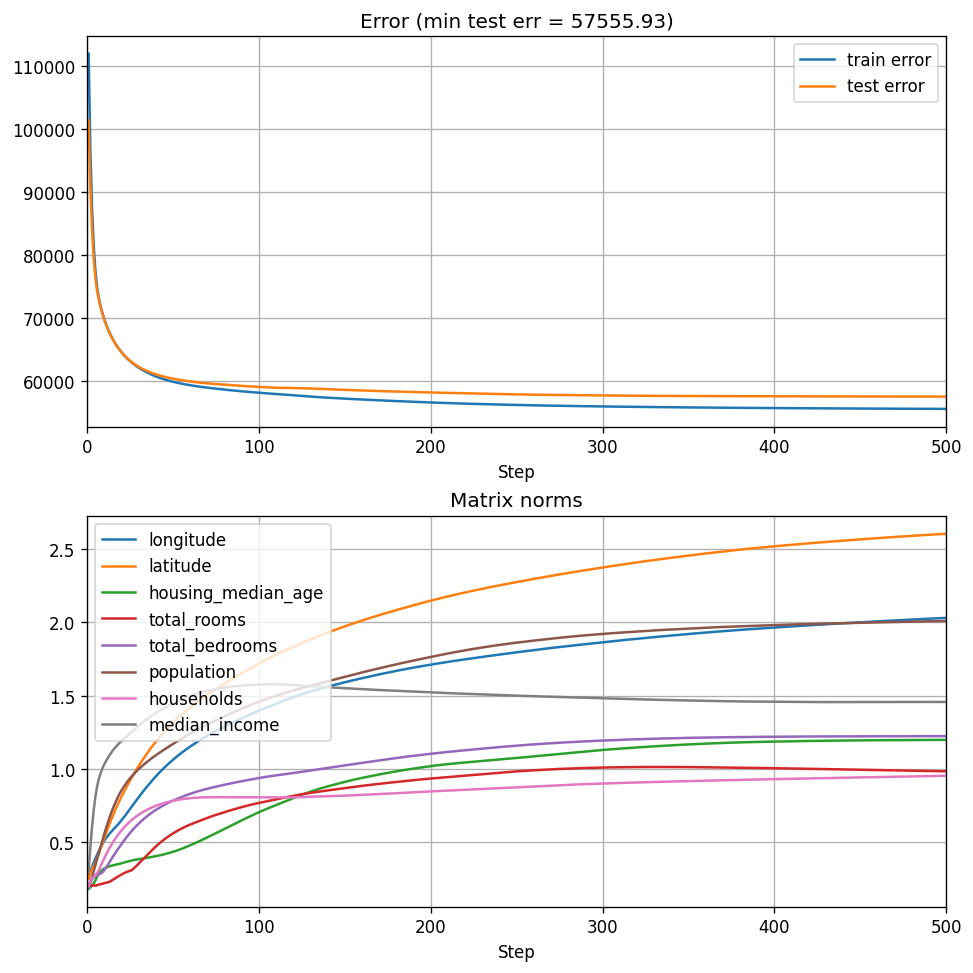

In [ ]:
def live_plot_training(dim, n_epochs):
    model = MultivariateSpectral(
        num_features=num_features, dim=dim, eigval_idx=dim // 2
    )
    criterion = nn.MSELoss()
    events = add_spectral_norms(train_model_stream(
        model, criterion, n_epochs=n_epochs
    ))
    plot_progress(
        events, max_step=n_epochs, recording_path=f'{dim}_{n_epochs}.gif'
    )

live_plot_training(5, 500)

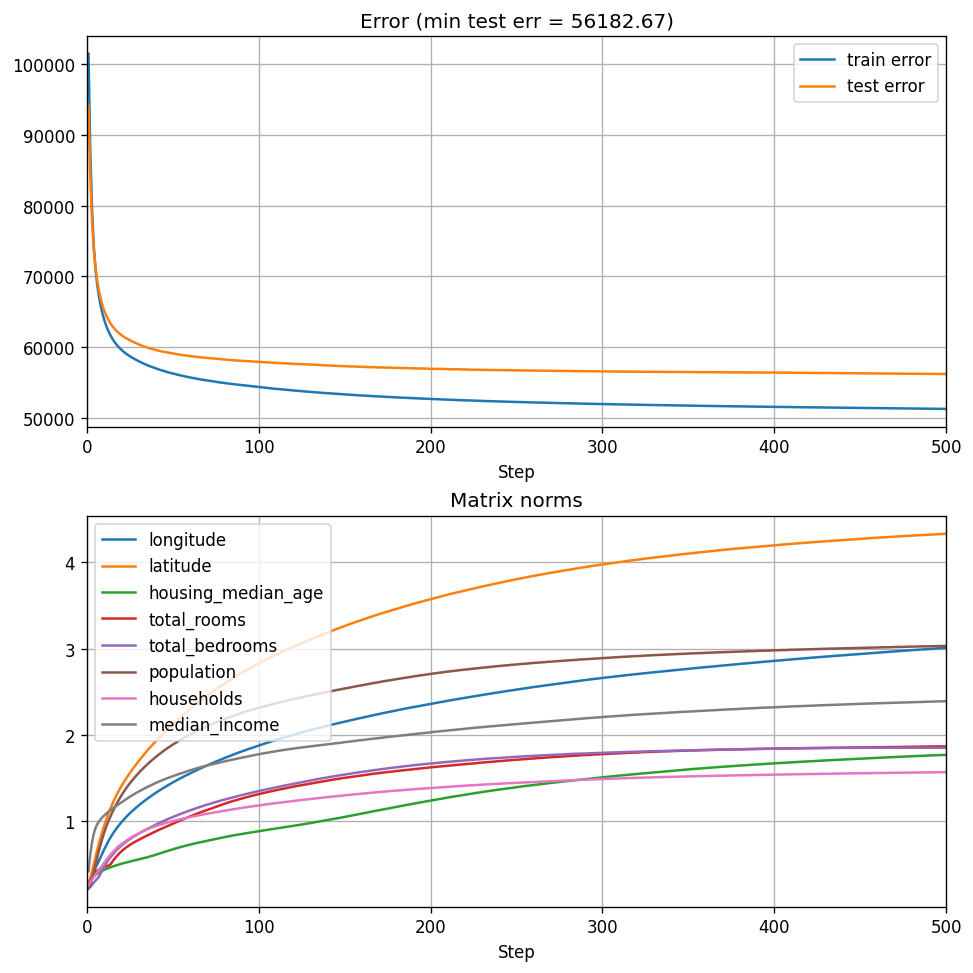

In [ ]:
live_plot_training(15, 500)

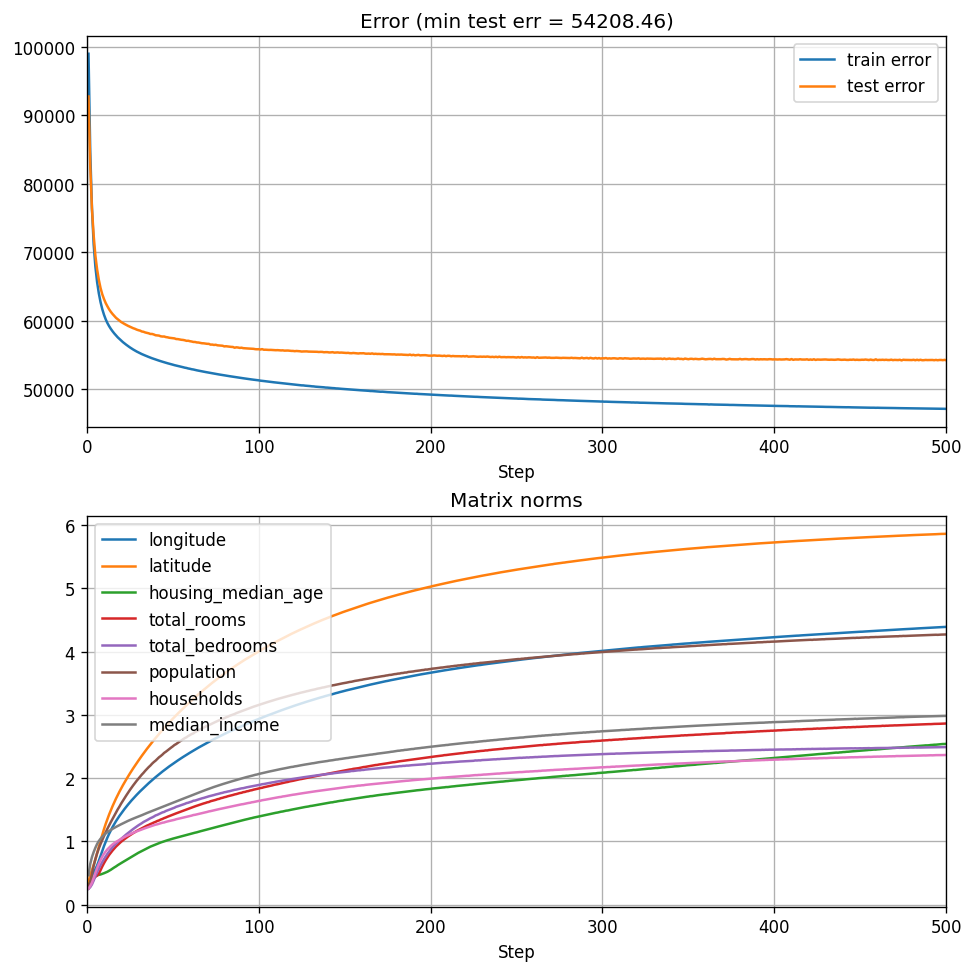

In [ ]:
live_plot_training(30, 500)

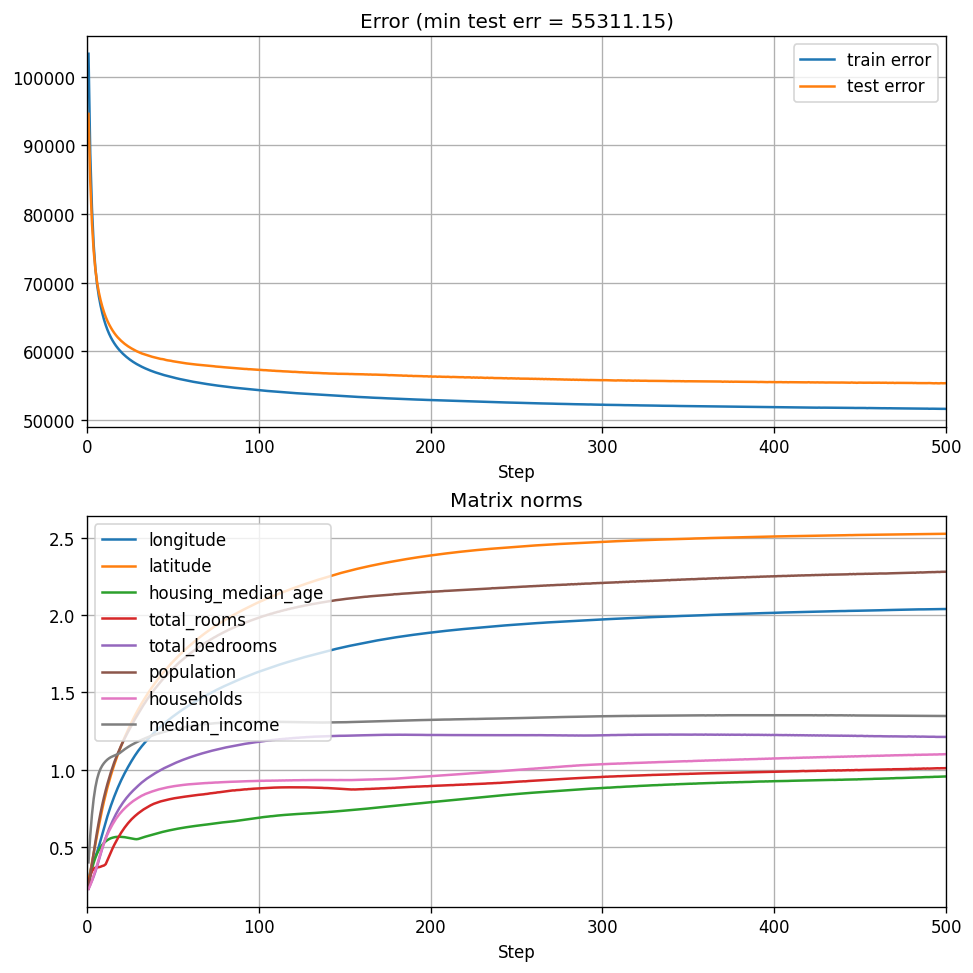

In [ ]:
def live_plot_reg_training(dim, n_epochs, reg_coef):
    model = MultivariateSpectral(
        num_features=num_features, dim=dim, eigval_idx=dim // 2
    )

    def penalty(net):
        matrices_sym = \
            net.A.tril() + net.A.tril(diagonal=-1).transpose(-1, -2)
        norms = tla.matrix_norm(matrices_sym, ord=2)
        return reg_coef * norms.sum()

    criterion = nn.MSELoss()
    events = add_spectral_norms(train_model_stream(
        model, criterion, n_epochs=n_epochs, regularizer=penalty
    ))
    plot_progress(events, max_step=n_epochs)

live_plot_reg_training(15, 500, 1e-3)